<a href="https://colab.research.google.com/github/RvsL/kaggle/blob/main/eruptions2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Новый раздел

In [1]:
import pandas as pd
import numpy as np
import zipfile as zf
import os
import datetime as dt
from tqdm import tqdm, tqdm_notebook
import re
import string
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')


def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name
def tstats(t, doplot = False):
    print('#'*20, get_df_name(t), t.shape)
    for _,i in enumerate(t):
        nulls = t[i].isna().sum()
        if nulls > 0:
            print(i,'=', t[i].nunique(), ',NULLS = ', nulls, ',% of nulls = ',round(100*nulls/t.shape[0]))
        else:
            print(i,'=', t[i].nunique())
    if doplot:
        print()
        print(t.sample(10))
        print()
        
warnings.filterwarnings('ignore')

In [3]:
!pip install catboost

     |████████████████████████████████| 65.8MB 77kB/s 


In [27]:
import lightgbm as lgb
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import f1_score,recall_score,precision_score,roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
import gc

def plot_history(history, metricname):
    recall = history.history[metricname]
    val_recall = history.history['val_' + metricname]
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(recall) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, recall, 'b', label='Training')
    plt.plot(x, val_recall, 'r', label='Validation')
    plt.title('Training and validation')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
from keras import regularizers as kreg
from keras.layers import Dense
from keras.models import Sequential

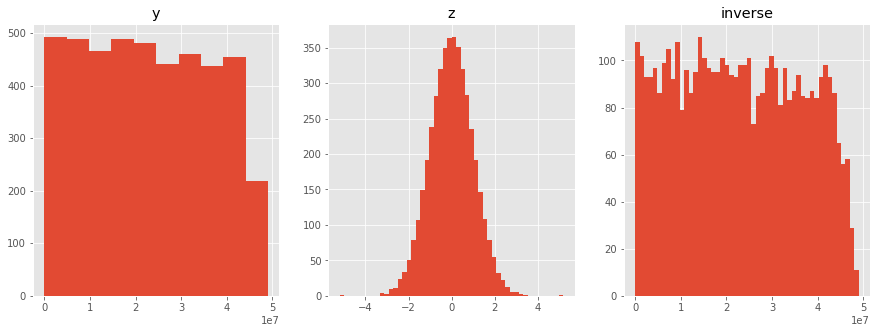

In [5]:
def prepare_data():
    
    t4m = pd.read_csv('/content/drive/MyDrive/2 - рабочее/32 - PMI/random/t4m_10.csv')
    t4p = pd.read_csv('/content/drive/MyDrive/2 - рабочее/32 - PMI/random/t4p_10.csv')
    features = t4m.columns[1:-1]
    target = 'time_to_eruption'

    df = t4m[t4m.columns[1:]].copy()
    t = df.corr()[target].reset_index()
    t[target] = abs(t[target])
    t.sort_values(by=target, ascending = False)

    t = t.loc[(t[target] > 0.05)&(t[target] < 1)].sort_values(by=target, ascending=False).reset_index()

    good_features = t['index'].values

    scaler = StandardScaler()

    # for train
    t = pd.DataFrame(scaler.fit_transform(t4m[good_features]), columns = good_features)

    t['sum_feat'] = t[good_features].sum(axis=1)
    t['mul_feat'] = t[good_features].prod(axis=1)
    t['s_m_feat'] = t['sum_feat'] * t['mul_feat']

    t4m['sum_feat'] = t['sum_feat'].values
    t4m['mul_feat'] = t['mul_feat'].values
    t4m['s_m_feat'] = t['s_m_feat'].values


    # for test
    t = pd.DataFrame(scaler.fit_transform(t4p[good_features]), columns = good_features)

    t['sum_feat'] = t[good_features].sum(axis=1)
    t['mul_feat'] = t[good_features].prod(axis=1)
    t['s_m_feat'] = t['sum_feat'] * t['mul_feat']

    t4p['sum_feat'] = t['sum_feat'].values
    t4p['mul_feat'] = t['mul_feat'].values
    t4p['s_m_feat'] = t['s_m_feat'].values

    feat = list(features)
    feat.append('sum_feat')
    feat.append('mul_feat')
    feat.append('s_m_feat')
    
    X, y = t4m[feat], t4m[target]

    data = y.values.reshape(-1, 1)

    from sklearn.preprocessing import QuantileTransformer

    rng = np.random.RandomState(304)
    qt = QuantileTransformer(n_quantiles=1000, output_distribution='normal',
                             random_state=rng)

    z = qt.fit_transform(data)
    z_back = qt.inverse_transform(z)

    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.hist(data)
    plt.title('y')

    plt.subplot(132)
    plt.hist(z, bins = 50)
    plt.title('z')

    plt.subplot(133)
    plt.hist(z_back, bins = 50)
    plt.title('inverse')

    plt.show()
    
    return t4m, t4p, X, y, z, feat, target, qt

t4m, t4p, X, y, z, feat, target, qt = prepare_data()

def de_qt(val):
    return qt.inverse_transform(val.reshape(-1, 1)).ravel()


In [30]:
%%time

from importlib import reload
reload(lgb)
n_fold = 2
folds = KFold(n_splits=n_fold, shuffle=True, random_state=101)

params = {
    "n_estimators": 2000,
    "boosting_type": "gbdt",
    "metric": "mae",
    "num_leaves": 66,
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "agging_freq": 3,
    "max_bins": 2048,
    "verbose": 0,
    "random_state": 101,
    "nthread": -1,
    "device": "cpu",
}

y_pred = np.zeros(t4p.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(t4m)):
    print(f"Fold {n_fold}:")
    trn_x, trn_y = t4m[feat].iloc[trn_idx], t4m[target].iloc[trn_idx]
    val_x, val_y = t4m[feat].iloc[val_idx], t4m[target].iloc[val_idx]
    
    model = lgb.LGBMRegressor(**params)
    
    model.fit(trn_x, trn_y, 
            eval_set= [(trn_x, trn_y), (val_x, val_y)], 
            eval_metric="mae", verbose=200, early_stopping_rounds=50
           )

    y_pred += model.predict(t4p[feat], num_iteration=model.best_iteration_) / folds.n_splits
    

plt.figure()
plt.hist(y_pred, bins=50)
plt.title('y pred distribution')
plt.show()

# my_submission = pd.DataFrame({
#     'segment_id':t4p['segment_id'].values,
#     'time_to_eruption':y_pred
# })

# my_submission.loc[my_submission[target] < 60000, target] = 60000 # in case of below zero predictions, correct them according to training data
# my_submission.loc[my_submission[target] > 4.8e+07, target] = 4.8e+07 # correct preds according to train limits

# my_submission.to_csv(f'submission_{ver}.csv', index=False)

ImportError: ignored

In [15]:
importances = model.feature_importances_

target_results = pd.DataFrame(importances, columns=[target])
target_results['feature'] = X_train.columns

t = target_results.sort_values(by = target)
t = t.tail(15)

plt.figure(figsize=(5, 5))
plt.title('Feature Importance')
plt.barh(t['feature'], t[target])
plt.show()

NotFittedError: ignored

In [17]:
%cd LightGBM
!mkdir build
%cd build
!cmake ../../LightGBM
!make -j4

/content/LightGBM
/content/LightGBM/build
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenMP_C: -fopenmp (found version "4.5") 
-- Found OpenMP_CXX: -fopenmp (found version "4.5") 
-- Found OpenMP: TRUE (found version "4.5")  
-- Performing Test MM_PREFETCH
-- Performing Test MM_PREFETCH - Success
-- Using _mm_prefetch
-- Performing Test MM_MALLOC
-- Performing Test MM_MALLOC - Success
-- Using _mm_malloc
-- Configuring done
-- Generatin

In [24]:
%cd ..
!ls

/content/LightGBM
build			     CONTRIBUTING.md  include	       R-package
build-cran-package.sh	     docker	      lib_lightgbm.so  src
build_r.R		     docs	      LICENSE	       swig
CMakeIntegratedOpenCL.cmake  eigen	      lightgbm	       tests
CMakeLists.txt		     examples	      pmml	       VERSION.txt
CODE_OF_CONDUCT.md	     external_libs    python-package   windows
compute			     helpers	      README.md


In [26]:
%cd python-package
!python3 setup.py install --gpu

/content/LightGBM/python-package
running install
INFO:LightGBM:Starting to compile the library.
INFO:LightGBM:Starting to compile with CMake.
running build
running build_py
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt
creating build
creating build/lib
creating build/lib/lightgbm
copying lightgbm/sklearn.py -> build/lib/lightgbm
copying lightgbm/__init__.py -> build/lib/lightgbm
copying lightgbm/engine.py -> build/lib/lightgbm
copying lightgbm/dask.py -> build/lib/lightgbm
copying lightgbm/callback.py -> build/lib/lightgbm
copying lightgbm/plotting.py -> build/lib/lightgbm
copying lightgbm/basic.py -> build/lib/lightgbm
copying lightgbm/libpath.py -> build/lib/lightgbm
copying lightgbm/compat.py -> build/lib/lightgbm
running egg_info
creating lightgbm.egg-info
writing lightgbm.egg-info/PKG-INFO
writing dependency_links to lightgbm.egg-info/dependency_links.txt
writin

In [19]:
!ls

CMakeCache.txt	CMakeFiles  cmake_install.cmake  Makefile
